In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, List
import json
import pickle

import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import OneCycleLR

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint


print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data
from transformer import LGBMLeavesEncoder, XGBLeavesEncoder, CATBLeavesEncoder

PyTorch version: 2.4.1
PyTorch Lightning version: 2.4.0


In [2]:
# set seeds for reproducibility
np.random.seed(2112)
pl.seed_everything(2112)

Seed set to 2112


2112

In [3]:
# useful callbacks
class LearningRateMonitor(pl.Callback):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if batch_idx % 100 == 0:  # Log every 100 batches
            lr = pl_module.optimizers().param_groups[0]['lr']
            pl_module.log('learning_rate', lr, prog_bar=True)   

class BestValRMSELogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.best_val_rmse = float('inf')

    def on_validation_epoch_end(self, trainer, pl_module):
        current_val_rmse = trainer.callback_metrics.get('val_rmse')
        if current_val_rmse is not None:
            self.best_val_rmse = min(self.best_val_rmse, current_val_rmse)
            pl_module.log('best_val_rmse', self.best_val_rmse, prog_bar=True)

***
### load and preprocess data

In [4]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [5]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])
text_cols = ["LudRules",]

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))
print("Text features:", len(text_cols))

Numerical features: 296
Categorical features: 5
Text features: 1


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    # scale=True,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 370
Categorical Columns: 5


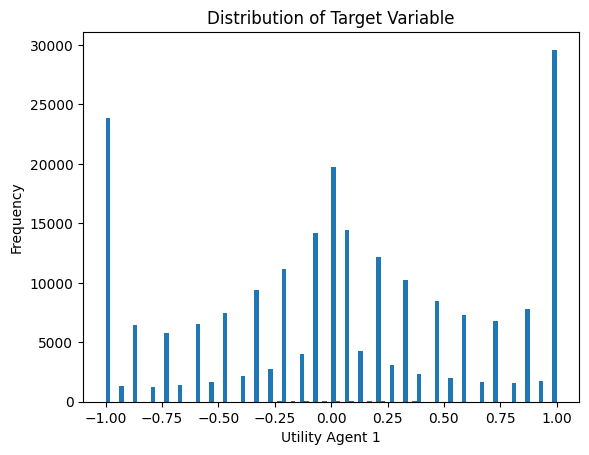

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
cat_input_dims = df_train[categorical_cols].nunique(axis=0).values.tolist()
print(cat_input_dims)

[72, 72, 4, 3, 4]


***
### train model


In [9]:
class MLP(pl.LightningModule):

    def __init__(self, 
            num_input_dim: int,
            cat_input_dims: list[int],
            output_dim: int,
            layers: str,
            dropout: float,
            embedding_dropout: float,
            learning_rate: float = 1e-3,
            weight_decay: float = 1e-5,
            initialization: str = 'kaiming_uniform',
            embedding_dim: Optional[List[int]] = None,
            pct_start: float = 0.2,
            div_factor: float = 10.0,
            final_div_factor: float = 1e4,
        ):
        super().__init__()
        self.save_hyperparameters()
        self.dropout = dropout
        self.embedding_dropout = embedding_dropout
        self.pct_start = pct_start
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor

        # Initialize embedding dimensions if not provided
        if embedding_dim is None:
            # Rule of thumb: min(50, num_unique // 2 + 1) for each categorical feature
            embedding_dim = [min(50, int(1 + np.ceil(np.sqrt(dim)))) for dim in cat_input_dims]

        elif len(embedding_dim) != len(cat_input_dims):
            raise ValueError("Length of embedding_dim must match number of categorical features.")

        self.embedding_dim = embedding_dim

        # Create embedding layers
        self.create_embeddings(cat_input_dims, embedding_dim)

        # Create backbone layers
        self.create_backbone(num_input_dim, layers)

        # Create head layers
        self.create_head(output_dim)

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.initialization = initialization

        self._init_weights()

        # Initialize lists to store validation outputs
        self.validation_targets = []
        self.validation_predictions = []

    def create_embeddings(self, cat_input_dims: list[int], embedding_dim: list[int]):
        self.embeddings = nn.ModuleList(
            [nn.Embedding(dim, emb_dim) for dim, emb_dim in zip(cat_input_dims, embedding_dim)]
        )
        self.embedding_dropout_layer = nn.Dropout(self.embedding_dropout)

    def create_backbone(self, num_input_dim: int, layers: str):
        # Calculate total input dimension after embeddings
        total_embedding_dim = sum(self.embedding_dim)
        total_input_dim = num_input_dim + total_embedding_dim

        # Parse layers string
        layer_sizes = [int(size) for size in layers.split('-')]

        # Create backbone network layers
        backbone_layers = []
        prev_size = total_input_dim
        for size in layer_sizes:
            backbone_layers.extend([
                nn.BatchNorm1d(prev_size),
                nn.Linear(prev_size, size),
                nn.ReLU(),
                nn.Dropout(self.hparams.dropout),
            ])
            prev_size = size
        self.backbone = nn.Sequential(*backbone_layers)
        self.backbone_output_size = prev_size

    def create_head(self, output_dim: int):
        # Output layer
        self.head = nn.Sequential(
            nn.BatchNorm1d(self.backbone_output_size),
            nn.Linear(self.backbone_output_size, output_dim)
        )

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if any(module is m for m in self.head.modules()):
                    nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('tanh'))
                else:
                    if self.initialization == 'kaiming_uniform':
                        nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
                    elif self.initialization == 'kaiming_normal':
                        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
                    elif self.initialization == 'xavier_uniform':
                        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
                    elif self.initialization == 'xavier_normal':
                        nn.init.xavier_normal_(module.weight, gain=nn.init.calculate_gain('relu'))
                    else:
                        raise ValueError(f"Unsupported initialization method: {self.initialization}")
                
                # Initialize bias to small values
                if module.bias is not None:
                    nn.init.uniform_(module.bias, -0.1, 0.1)

    def forward(self, x_num, x_cat):
        # Process categorical variables
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        embedded = torch.cat(embedded, dim=1)
        embedded = self.embedding_dropout_layer(embedded)
        
        # Concatenate numerical and embedded categorical features
        x = torch.cat([x_num, embedded], dim=1)
        
        # Pass through backbone
        x = self.backbone(x)
        
        # Pass through head
        x = self.head(x)
        x = nn.functional.hardtanh(x)

        return x.squeeze(-1)

    def training_step(self, batch, batch_idx):
        x_num, x_cat, y = batch
        y_hat = self(x_num, x_cat)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_num, x_cat, y = batch
        y_hat = self(x_num, x_cat)
        loss = F.mse_loss(y_hat, y)
        self.log('valid_loss', loss, prog_bar=True)
        # Store targets and predictions for later use
        self.validation_targets.append(y)
        self.validation_predictions.append(y_hat)
        return loss
    
    def predict_step(self, batch, batch_idx):
        if len(batch) == 2:
            x_num, x_cat = batch
        elif len(batch) == 3:
            x_num, x_cat, _ = batch
        y_hat = self(x_num, x_cat)
        return y_hat

    def on_validation_epoch_end(self):
        # Concatenate all targets and predictions
        y = torch.cat(self.validation_targets)
        y_hat = torch.cat(self.validation_predictions)
        rmse = torch.sqrt(F.mse_loss(y_hat, y))
        self.log('val_rmse', rmse, prog_bar=True)
        # Clear the lists for next epoch
        self.validation_targets.clear()
        self.validation_predictions.clear()
                
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay,
        )
        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=self.pct_start,
            div_factor=self.div_factor,
            final_div_factor=self.final_div_factor,
            anneal_strategy='cos',
            cycle_momentum=True,
            base_momentum=0.85,
            max_momentum=0.95,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
            },
        }

In [10]:
params = {
    'batch_size': 448,
    'dropout': 0.0,
    'embedding_dropout': 0.2,
    'input_layer_size': 1024,
    'n_layers': 4,
    'learning_rate': 0.0017902381479678216,
    'weight_decay': 0.0003339096474946611,
    'pct_start': 0.05,
    'div_factor': 74.0,
    'final_div_factor': 39.31519465021811
}

In [11]:
## EXP: scale=False, input_layer_size=1024, LGBMLeavesEncoder num_leaves=31

# Define the number of folds for cross-validation
split_list = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train  = df_train.iloc[train_index][numerical_cols + categorical_cols]
    y_train = df_train.iloc[train_index]['utility_agent1']
    X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
    y_valid = df_train.iloc[val_index]['utility_agent1']

    lgbm_encoder = LGBMLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        n_estimators=100,
        num_leaves=31,
        random_state=2112,
    )
    lgbm_encoder.fit(X_train, y_train)
    X_train = lgbm_encoder.transform(X_train, verbose=True)
    X_valid = lgbm_encoder.transform(X_valid)

    _categorical_cols = categorical_cols + lgbm_encoder.new_columns
    _cat_input_dims = X_train[_categorical_cols].nunique(axis=0).values.tolist()

    train_dataset = TensorDataset(
        torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_valid.values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=_cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        embedding_dropout=params['embedding_dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization="kaiming_uniform",
        pct_start=params["pct_start"],
        div_factor=params["div_factor"],
        final_div_factor=params["final_div_factor"],
    )
    trainer = pl.Trainer(
        # min_epochs=10, 
        max_epochs=100, 
        # deterministic=True,
        accelerator="mps", 
        callbacks=[
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                mode='min',
                verbose=False
            ), 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)
    trained_models.append(model)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = y_valid.values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred
    oof.loc[val_index, 'fold'] = fold

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# oof.to_csv(path_results / 'oof_mlp_cv1.csv', index=False)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9589
[LightGBM] [Info] Number of data points in the train set: 190558, number of used features: 368
[LightGBM] [Info] Start training from score 0.040548
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 23.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.379     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 1 - RMSE: 0.4385396775537597
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9722
[LightGBM] [Info] Number of data points in the train set: 196422, number of used features: 373
[LightGBM] [Info] Start training from score 0.047370
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 23.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.379     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 2 - RMSE: 0.4636793613470107
Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9660
[LightGBM] [Info] Number of data points in the train set: 193178, number of used features: 370
[LightGBM] [Info] Start training from score 0.045943
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 23.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.379     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 3 - RMSE: 0.45045718336169105
Fold 4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9580
[LightGBM] [Info] Number of data points in the train set: 190888, number of used features: 374
[LightGBM] [Info] Start training from score 0.047922
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 23.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.379     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 4 - RMSE: 0.4590206196674111
Fold 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9603
[LightGBM] [Info] Number of data points in the train set: 186516, number of used features: 373
[LightGBM] [Info] Start training from score 0.042994
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 23.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.379     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 5 - RMSE: 0.4235808585301436
List of oof scores: [0.4385396775537597, 0.4636793613470107, 0.45045718336169105, 0.4590206196674111, 0.4235808585301436]
Average oof score: 0.4470555400920032


In [12]:
## EXP: scale=False, input_layer_size=1024, LGBMLeavesEncoder num_leaves=63

# Define the number of folds for cross-validation
split_list = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train  = df_train.iloc[train_index][numerical_cols + categorical_cols]
    y_train = df_train.iloc[train_index]['utility_agent1']
    X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
    y_valid = df_train.iloc[val_index]['utility_agent1']

    lgbm_encoder = LGBMLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        n_estimators=100,
        num_leaves=63,
        random_state=2112,
    )
    lgbm_encoder.fit(X_train, y_train)
    X_train = lgbm_encoder.transform(X_train, verbose=True)
    X_valid = lgbm_encoder.transform(X_valid)

    _categorical_cols = categorical_cols + lgbm_encoder.new_columns
    _cat_input_dims = X_train[_categorical_cols].nunique(axis=0).values.tolist()

    train_dataset = TensorDataset(
        torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_valid.values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=_cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        embedding_dropout=params['embedding_dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization="kaiming_uniform",
        pct_start=params["pct_start"],
        div_factor=params["div_factor"],
        final_div_factor=params["final_div_factor"],
    )
    trainer = pl.Trainer(
        # min_epochs=10, 
        max_epochs=100, 
        # deterministic=True,
        accelerator="mps", 
        callbacks=[
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                mode='min',
                verbose=False
            ), 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)
    trained_models.append(model)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = y_valid.values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred
    oof.loc[val_index, 'fold'] = fold

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# oof.to_csv(path_results / 'oof_mlp_cv1.csv', index=False)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9589
[LightGBM] [Info] Number of data points in the train set: 190558, number of used features: 368
[LightGBM] [Info] Start training from score 0.040548
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 58.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.340     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 1 - RMSE: 0.43545434560795915
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9722
[LightGBM] [Info] Number of data points in the train set: 196422, number of used features: 373
[LightGBM] [Info] Start training from score 0.047370
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 58.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.340     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 2 - RMSE: 0.45135573160344145
Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9660
[LightGBM] [Info] Number of data points in the train set: 193178, number of used features: 370
[LightGBM] [Info] Start training from score 0.045943
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 58.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.340     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 3 - RMSE: 0.44585486609455605
Fold 4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9580
[LightGBM] [Info] Number of data points in the train set: 190888, number of used features: 374
[LightGBM] [Info] Start training from score 0.047922
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 58.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.340     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 4 - RMSE: 0.45010607277979575
Fold 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9603
[LightGBM] [Info] Number of data points in the train set: 186516, number of used features: 373
[LightGBM] [Info] Start training from score 0.042994
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 58.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.340     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 5 - RMSE: 0.41080257015112914
List of oof scores: [0.43545434560795915, 0.45135573160344145, 0.44585486609455605, 0.45010607277979575, 0.41080257015112914]
Average oof score: 0.4387147172473764


In [13]:
## EXP: scale=False, input_layer_size=1024, LGBMLeavesEncoder num_leaves=127

# Define the number of folds for cross-validation
split_list = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train  = df_train.iloc[train_index][numerical_cols + categorical_cols]
    y_train = df_train.iloc[train_index]['utility_agent1']
    X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
    y_valid = df_train.iloc[val_index]['utility_agent1']

    lgbm_encoder = LGBMLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        n_estimators=100,
        num_leaves=127,
        random_state=2112,
    )
    lgbm_encoder.fit(X_train, y_train)
    X_train = lgbm_encoder.transform(X_train, verbose=True)
    X_valid = lgbm_encoder.transform(X_valid)

    _categorical_cols = categorical_cols + lgbm_encoder.new_columns
    _cat_input_dims = X_train[_categorical_cols].nunique(axis=0).values.tolist()

    train_dataset = TensorDataset(
        torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_valid.values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=_cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        embedding_dropout=params['embedding_dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization="kaiming_uniform",
        pct_start=params["pct_start"],
        div_factor=params["div_factor"],
        final_div_factor=params["final_div_factor"],
    )
    trainer = pl.Trainer(
        # min_epochs=10, 
        max_epochs=100, 
        # deterministic=True,
        accelerator="mps", 
        callbacks=[
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                mode='min',
                verbose=False
            ), 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)
    trained_models.append(model)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = y_valid.values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred
    oof.loc[val_index, 'fold'] = fold

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# oof.to_csv(path_results / 'oof_mlp_cv1.csv', index=False)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9589
[LightGBM] [Info] Number of data points in the train set: 190558, number of used features: 368
[LightGBM] [Info] Start training from score 0.040548
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 166 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.4 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.415    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 1 - RMSE: 0.44315884704508146
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9722
[LightGBM] [Info] Number of data points in the train set: 196422, number of used features: 373
[LightGBM] [Info] Start training from score 0.047370
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 166 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.4 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.415    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 2 - RMSE: 0.4510108662523928
Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9660
[LightGBM] [Info] Number of data points in the train set: 193178, number of used features: 370
[LightGBM] [Info] Start training from score 0.045943
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 166 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.4 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.415    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 3 - RMSE: 0.44984570283445174
Fold 4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9580
[LightGBM] [Info] Number of data points in the train set: 190888, number of used features: 374
[LightGBM] [Info] Start training from score 0.047922
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 166 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.4 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.415    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 4 - RMSE: 0.4458989069193436
Fold 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9603
[LightGBM] [Info] Number of data points in the train set: 186516, number of used features: 373
[LightGBM] [Info] Start training from score 0.042994
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 166 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.4 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.415    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 5 - RMSE: 0.40962127504544443
List of oof scores: [0.44315884704508146, 0.4510108662523928, 0.44984570283445174, 0.4458989069193436, 0.40962127504544443]
Average oof score: 0.4399071196193428


In [14]:
## EXP: scale=False, input_layer_size=1024, LGBMLeavesEncoder num_leaves=255

# Define the number of folds for cross-validation
split_list = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train  = df_train.iloc[train_index][numerical_cols + categorical_cols]
    y_train = df_train.iloc[train_index]['utility_agent1']
    X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
    y_valid = df_train.iloc[val_index]['utility_agent1']

    lgbm_encoder = LGBMLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        n_estimators=100,
        num_leaves=255,
        random_state=2112,
    )
    lgbm_encoder.fit(X_train, y_train)
    X_train = lgbm_encoder.transform(X_train, verbose=True)
    X_valid = lgbm_encoder.transform(X_valid)

    _categorical_cols = categorical_cols + lgbm_encoder.new_columns
    _cat_input_dims = X_train[_categorical_cols].nunique(axis=0).values.tolist()

    train_dataset = TensorDataset(
        torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_valid.values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=_cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        embedding_dropout=params['embedding_dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization="kaiming_uniform",
        pct_start=params["pct_start"],
        div_factor=params["div_factor"],
        final_div_factor=params["final_div_factor"],
    )
    trainer = pl.Trainer(
        # min_epochs=10, 
        max_epochs=100, 
        # deterministic=True,
        accelerator="mps", 
        callbacks=[
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                mode='min',
                verbose=False
            ), 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)
    trained_models.append(model)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = y_valid.values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred
    oof.loc[val_index, 'fold'] = fold

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# oof.to_csv(path_results / 'oof_mlp_cv1.csv', index=False)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9589
[LightGBM] [Info] Number of data points in the train set: 190558, number of used features: 368
[LightGBM] [Info] Start training from score 0.040548
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 434 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.130    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 1 - RMSE: 0.4546795445680267
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9722
[LightGBM] [Info] Number of data points in the train set: 196422, number of used features: 373
[LightGBM] [Info] Start training from score 0.047370
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 434 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.130    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 2 - RMSE: 0.45259520033258255
Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9660
[LightGBM] [Info] Number of data points in the train set: 193178, number of used features: 370
[LightGBM] [Info] Start training from score 0.045943
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 434 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.130    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 3 - RMSE: 0.45786076251112834
Fold 4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9580
[LightGBM] [Info] Number of data points in the train set: 190888, number of used features: 374
[LightGBM] [Info] Start training from score 0.047922
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 434 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.130    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 4 - RMSE: 0.4620326849052131
Fold 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9603
[LightGBM] [Info] Number of data points in the train set: 186516, number of used features: 373
[LightGBM] [Info] Start training from score 0.042994
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 434 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.130    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 5 - RMSE: 0.4171973592575205
List of oof scores: [0.4546795445680267, 0.45259520033258255, 0.45786076251112834, 0.4620326849052131, 0.4171973592575205]
Average oof score: 0.44887311031489424


In [15]:
## EXP: scale=False, input_layer_size=1024, LGBMLeavesEncoder num_leaves=511

# Define the number of folds for cross-validation
split_list = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train  = df_train.iloc[train_index][numerical_cols + categorical_cols]
    y_train = df_train.iloc[train_index]['utility_agent1']
    X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
    y_valid = df_train.iloc[val_index]['utility_agent1']

    lgbm_encoder = LGBMLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        n_estimators=100,
        num_leaves=511,
        random_state=2112,
    )
    lgbm_encoder.fit(X_train, y_train)
    X_train = lgbm_encoder.transform(X_train, verbose=True)
    X_valid = lgbm_encoder.transform(X_valid)

    _categorical_cols = categorical_cols + lgbm_encoder.new_columns
    _cat_input_dims = X_train[_categorical_cols].nunique(axis=0).values.tolist()

    train_dataset = TensorDataset(
        torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_valid.values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=_cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        embedding_dropout=params['embedding_dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization="kaiming_uniform",
        pct_start=params["pct_start"],
        div_factor=params["div_factor"],
        final_div_factor=params["final_div_factor"],
    )
    trainer = pl.Trainer(
        # min_epochs=10, 
        max_epochs=100, 
        # deterministic=True,
        accelerator="mps", 
        callbacks=[
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                mode='min',
                verbose=False
            ), 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)
    trained_models.append(model)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = y_valid.values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred
    oof.loc[val_index, 'fold'] = fold

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# oof.to_csv(path_results / 'oof_mlp_cv1.csv', index=False)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9589
[LightGBM] [Info] Number of data points in the train set: 190558, number of used features: 368
[LightGBM] [Info] Start training from score 0.040548
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 1.2 M  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 3.6 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.175    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 1 - RMSE: 0.45845736974886364
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9722
[LightGBM] [Info] Number of data points in the train set: 196422, number of used features: 373
[LightGBM] [Info] Start training from score 0.047370
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 1.2 M  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 3.6 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.175    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 2 - RMSE: 0.45282796735280373
Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9660
[LightGBM] [Info] Number of data points in the train set: 193178, number of used features: 370
[LightGBM] [Info] Start training from score 0.045943
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 1.2 M  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 3.6 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.175    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 3 - RMSE: 0.4467152076006132
Fold 4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9580
[LightGBM] [Info] Number of data points in the train set: 190888, number of used features: 374
[LightGBM] [Info] Start training from score 0.047922
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 1.2 M  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 3.6 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.175    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 4 - RMSE: 0.4553040843077686
Fold 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9603
[LightGBM] [Info] Number of data points in the train set: 186516, number of used features: 373
[LightGBM] [Info] Start training from score 0.042994
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 1.2 M  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 3.6 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.175    Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 5 - RMSE: 0.4244732686974537
List of oof scores: [0.45845736974886364, 0.45282796735280373, 0.4467152076006132, 0.4553040843077686, 0.4244732686974537]
Average oof score: 0.4475555795415005


In [16]:
## EXP: scale=False, input_layer_size=1024, LGBMLeavesEncoder num_leaves=31 & n_estimators=50

# Define the number of folds for cross-validation
split_list = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train  = df_train.iloc[train_index][numerical_cols + categorical_cols]
    y_train = df_train.iloc[train_index]['utility_agent1']
    X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
    y_valid = df_train.iloc[val_index]['utility_agent1']

    lgbm_encoder = LGBMLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        n_estimators=50,
        num_leaves=31,
        random_state=2112,
    )
    lgbm_encoder.fit(X_train, y_train)
    X_train = lgbm_encoder.transform(X_train, verbose=True)
    X_valid = lgbm_encoder.transform(X_valid)

    _categorical_cols = categorical_cols + lgbm_encoder.new_columns
    _cat_input_dims = X_train[_categorical_cols].nunique(axis=0).values.tolist()

    train_dataset = TensorDataset(
        torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_valid.values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=_cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        embedding_dropout=params['embedding_dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization="kaiming_uniform",
        pct_start=params["pct_start"],
        div_factor=params["div_factor"],
        final_div_factor=params["final_div_factor"],
    )
    trainer = pl.Trainer(
        # min_epochs=10, 
        max_epochs=100, 
        # deterministic=True,
        accelerator="mps", 
        callbacks=[
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                mode='min',
                verbose=False
            ), 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)
    trained_models.append(model)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = y_valid.values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred
    oof.loc[val_index, 'fold'] = fold

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# oof.to_csv(path_results / 'oof_mlp_cv1.csv', index=False)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9589
[LightGBM] [Info] Number of data points in the train set: 190558, number of used features: 368
[LightGBM] [Info] Start training from score 0.040548
Adding 50 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 12.3 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.5 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.899     Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 1 - RMSE: 0.44668619288551215
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9722
[LightGBM] [Info] Number of data points in the train set: 196422, number of used features: 373
[LightGBM] [Info] Start training from score 0.047370
Adding 50 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 12.3 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.5 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.899     Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 2 - RMSE: 0.4597127196760133
Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9660
[LightGBM] [Info] Number of data points in the train set: 193178, number of used features: 370
[LightGBM] [Info] Start training from score 0.045943
Adding 50 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 12.3 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.5 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.899     Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 3 - RMSE: 0.4620934939030284
Fold 4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9580
[LightGBM] [Info] Number of data points in the train set: 190888, number of used features: 374
[LightGBM] [Info] Start training from score 0.047922
Adding 50 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 12.3 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.5 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.899     Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 4 - RMSE: 0.46146829075590745
Fold 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9603
[LightGBM] [Info] Number of data points in the train set: 186516, number of used features: 373
[LightGBM] [Info] Start training from score 0.042994
Adding 50 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 12.3 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.5 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.899     Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 5 - RMSE: 0.422750316566109
List of oof scores: [0.44668619288551215, 0.4597127196760133, 0.4620934939030284, 0.46146829075590745, 0.422750316566109]
Average oof score: 0.45054220275731405


In [17]:
## EXP: scale=False, input_layer_size=1024, LGBMLeavesEncoder num_leaves=31 & n_estimators=100

# Define the number of folds for cross-validation
split_list = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train  = df_train.iloc[train_index][numerical_cols + categorical_cols]
    y_train = df_train.iloc[train_index]['utility_agent1']
    X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
    y_valid = df_train.iloc[val_index]['utility_agent1']

    lgbm_encoder = LGBMLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        n_estimators=100,
        num_leaves=31,
        random_state=2112,
    )
    lgbm_encoder.fit(X_train, y_train)
    X_train = lgbm_encoder.transform(X_train, verbose=True)
    X_valid = lgbm_encoder.transform(X_valid)

    _categorical_cols = categorical_cols + lgbm_encoder.new_columns
    _cat_input_dims = X_train[_categorical_cols].nunique(axis=0).values.tolist()

    train_dataset = TensorDataset(
        torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_valid.values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=_cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        embedding_dropout=params['embedding_dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization="kaiming_uniform",
        pct_start=params["pct_start"],
        div_factor=params["div_factor"],
        final_div_factor=params["final_div_factor"],
    )
    trainer = pl.Trainer(
        # min_epochs=10, 
        max_epochs=100, 
        # deterministic=True,
        accelerator="mps", 
        callbacks=[
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                mode='min',
                verbose=False
            ), 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)
    trained_models.append(model)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = y_valid.values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred
    oof.loc[val_index, 'fold'] = fold

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# oof.to_csv(path_results / 'oof_mlp_cv1.csv', index=False)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9589
[LightGBM] [Info] Number of data points in the train set: 190558, number of used features: 368
[LightGBM] [Info] Start training from score 0.040548
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 23.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.379     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 1 - RMSE: 0.43591955051275433
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9722
[LightGBM] [Info] Number of data points in the train set: 196422, number of used features: 373
[LightGBM] [Info] Start training from score 0.047370
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 23.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.379     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 2 - RMSE: 0.4665020543895091
Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9660
[LightGBM] [Info] Number of data points in the train set: 193178, number of used features: 370
[LightGBM] [Info] Start training from score 0.045943
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 23.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.379     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 3 - RMSE: 0.4558959709766073
Fold 4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9580
[LightGBM] [Info] Number of data points in the train set: 190888, number of used features: 374
[LightGBM] [Info] Start training from score 0.047922
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 23.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.379     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 4 - RMSE: 0.4544206177815661
Fold 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9603
[LightGBM] [Info] Number of data points in the train set: 186516, number of used features: 373
[LightGBM] [Info] Start training from score 0.042994
Adding 100 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 23.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 1.8 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.379     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 5 - RMSE: 0.42170014781850224
List of oof scores: [0.43591955051275433, 0.4665020543895091, 0.4558959709766073, 0.4544206177815661, 0.42170014781850224]
Average oof score: 0.44688766829578785


In [18]:
## EXP: scale=False, input_layer_size=1024, LGBMLeavesEncoder num_leaves=31 & n_estimators=200

# Define the number of folds for cross-validation
split_list = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train  = df_train.iloc[train_index][numerical_cols + categorical_cols]
    y_train = df_train.iloc[train_index]['utility_agent1']
    X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
    y_valid = df_train.iloc[val_index]['utility_agent1']

    lgbm_encoder = LGBMLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        n_estimators=200,
        num_leaves=31,
        random_state=2112,
    )
    lgbm_encoder.fit(X_train, y_train)
    X_train = lgbm_encoder.transform(X_train, verbose=True)
    X_valid = lgbm_encoder.transform(X_valid)

    _categorical_cols = categorical_cols + lgbm_encoder.new_columns
    _cat_input_dims = X_train[_categorical_cols].nunique(axis=0).values.tolist()

    train_dataset = TensorDataset(
        torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_valid.values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=_cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        embedding_dropout=params['embedding_dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization="kaiming_uniform",
        pct_start=params["pct_start"],
        div_factor=params["div_factor"],
        final_div_factor=params["final_div_factor"],
    )
    trainer = pl.Trainer(
        # min_epochs=10, 
        max_epochs=100, 
        # deterministic=True,
        accelerator="mps", 
        callbacks=[
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                mode='min',
                verbose=False
            ), 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)
    trained_models.append(model)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = y_valid.values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred
    oof.loc[val_index, 'fold'] = fold

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# oof.to_csv(path_results / 'oof_mlp_cv1.csv', index=False)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9589
[LightGBM] [Info] Number of data points in the train set: 190558, number of used features: 368
[LightGBM] [Info] Start training from score 0.040548
Adding 200 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 44.9 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.5 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.339    Total estimated model params size (MB)
227       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 1 - RMSE: 0.43634859568737033
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9722
[LightGBM] [Info] Number of data points in the train set: 196422, number of used features: 373
[LightGBM] [Info] Start training from score 0.047370
Adding 200 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 44.9 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.5 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.339    Total estimated model params size (MB)
227       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 2 - RMSE: 0.45174671516122505
Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9660
[LightGBM] [Info] Number of data points in the train set: 193178, number of used features: 370
[LightGBM] [Info] Start training from score 0.045943
Adding 200 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 44.9 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.5 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.339    Total estimated model params size (MB)
227       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 3 - RMSE: 0.4438317477134888
Fold 4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9580
[LightGBM] [Info] Number of data points in the train set: 190888, number of used features: 374
[LightGBM] [Info] Start training from score 0.047922
Adding 200 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 44.9 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.5 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.339    Total estimated model params size (MB)
227       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 4 - RMSE: 0.45652915119200665
Fold 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9603
[LightGBM] [Info] Number of data points in the train set: 186516, number of used features: 373
[LightGBM] [Info] Start training from score 0.042994
Adding 200 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 44.9 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.5 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.339    Total estimated model params size (MB)
227       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 5 - RMSE: 0.4156507796168683
List of oof scores: [0.43634859568737033, 0.45174671516122505, 0.4438317477134888, 0.45652915119200665, 0.4156507796168683]
Average oof score: 0.44082139787419183


In [12]:
## restart here

## EXP: scale=False, input_layer_size=1024, LGBMLeavesEncoder num_leaves=31 & n_estimators=500

# Define the number of folds for cross-validation
split_list = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train  = df_train.iloc[train_index][numerical_cols + categorical_cols]
    y_train = df_train.iloc[train_index]['utility_agent1']
    X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
    y_valid = df_train.iloc[val_index]['utility_agent1']

    lgbm_encoder = LGBMLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        n_estimators=500,
        num_leaves=31,
        random_state=2112,
    )
    lgbm_encoder.fit(X_train, y_train)
    X_train = lgbm_encoder.transform(X_train, verbose=True)
    X_valid = lgbm_encoder.transform(X_valid)

    _categorical_cols = categorical_cols + lgbm_encoder.new_columns
    _cat_input_dims = X_train[_categorical_cols].nunique(axis=0).values.tolist()

    train_dataset = TensorDataset(
        torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_valid.values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=_cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        embedding_dropout=params['embedding_dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization="kaiming_uniform",
        pct_start=params["pct_start"],
        div_factor=params["div_factor"],
        final_div_factor=params["final_div_factor"],
    )
    trainer = pl.Trainer(
        # min_epochs=10, 
        max_epochs=100, 
        # deterministic=True,
        accelerator="mps", 
        callbacks=[
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                mode='min',
                verbose=False
            ), 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)
    trained_models.append(model)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = y_valid.values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred
    oof.loc[val_index, 'fold'] = fold

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# oof.to_csv(path_results / 'oof_mlp_cv1.csv', index=False)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9589
[LightGBM] [Info] Number of data points in the train set: 190558, number of used features: 368
[LightGBM] [Info] Start training from score 0.040548
Adding 500 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 109 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 4.7 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.217    Total estimated model params size (MB)
527       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 1 - RMSE: 0.4422030658582262
Fold 2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9722
[LightGBM] [Info] Number of data points in the train set: 196422, number of used features: 373
[LightGBM] [Info] Start training from score 0.047370
Adding 500 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 109 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 4.7 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.217    Total estimated model params size (MB)
527       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 2 - RMSE: 0.4545342806111581
Fold 3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9660
[LightGBM] [Info] Number of data points in the train set: 193178, number of used features: 370
[LightGBM] [Info] Start training from score 0.045943
Adding 500 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 109 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 4.7 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.217    Total estimated model params size (MB)
527       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 3 - RMSE: 0.44368945996554027
Fold 4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9580
[LightGBM] [Info] Number of data points in the train set: 190888, number of used features: 374
[LightGBM] [Info] Start training from score 0.047922
Adding 500 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 109 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 4.7 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.217    Total estimated model params size (MB)
527       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 4 - RMSE: 0.4595110715626153
Fold 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9603
[LightGBM] [Info] Number of data points in the train set: 186516, number of used features: 373
[LightGBM] [Info] Start training from score 0.042994
Adding 500 new columns from LGBM leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 109 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 4.7 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.217    Total estimated model params size (MB)
527       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 5 - RMSE: 0.4207574670582172
List of oof scores: [0.4422030658582262, 0.4545342806111581, 0.44368945996554027, 0.4595110715626153, 0.4207574670582172]
Average oof score: 0.4441390690111514


In [13]:
## EXP: scale=False, input_layer_size=1024, CATBLeavesEncoder depth=6

# Define the number of folds for cross-validation
split_list = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train  = df_train.iloc[train_index][numerical_cols + categorical_cols]
    y_train = df_train.iloc[train_index]['utility_agent1']
    X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
    y_valid = df_train.iloc[val_index]['utility_agent1']

    catb_encoder = CATBLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        random_state=2112,
        iterations=100,
        depth=7,
    )
    catb_encoder.fit(X_train, y_train)
    X_train = catb_encoder.transform(X_train, verbose=True)
    X_valid = catb_encoder.transform(X_valid)

    _categorical_cols = categorical_cols + catb_encoder.new_columns
    _cat_input_dims = X_train[_categorical_cols].nunique(axis=0).values.tolist()


    train_dataset = TensorDataset(
        torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_valid.values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=_cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        embedding_dropout=params['embedding_dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization="kaiming_uniform",
        pct_start=params["pct_start"],
        div_factor=params["div_factor"],
        final_div_factor=params["final_div_factor"],
    )

    trainer = pl.Trainer(
        # min_epochs=10, 
        max_epochs=100, 
        # deterministic=True,
        accelerator="mps", 
        callbacks=[
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                mode='min',
                verbose=False
            ), 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)
    trained_models.append(model)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = y_valid.values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred
    oof.loc[val_index, 'fold'] = fold

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# oof.to_csv(path_results / 'oof_mlp_cv1.csv', index=False)


Fold 1
Learning rate set to 0.5
0:	learn: 0.5574316	total: 82.9ms	remaining: 8.2s
1:	learn: 0.5169480	total: 105ms	remaining: 5.15s
2:	learn: 0.5031634	total: 130ms	remaining: 4.2s
3:	learn: 0.4849591	total: 155ms	remaining: 3.72s
4:	learn: 0.4716229	total: 179ms	remaining: 3.4s
5:	learn: 0.4649193	total: 200ms	remaining: 3.13s
6:	learn: 0.4606412	total: 225ms	remaining: 2.98s
7:	learn: 0.4521898	total: 247ms	remaining: 2.83s
8:	learn: 0.4457586	total: 277ms	remaining: 2.8s
9:	learn: 0.4422965	total: 310ms	remaining: 2.79s
10:	learn: 0.4367108	total: 333ms	remaining: 2.69s
11:	learn: 0.4340798	total: 357ms	remaining: 2.62s
12:	learn: 0.4307425	total: 380ms	remaining: 2.54s
13:	learn: 0.4286020	total: 402ms	remaining: 2.47s
14:	learn: 0.4263465	total: 424ms	remaining: 2.4s
15:	learn: 0.4237908	total: 447ms	remaining: 2.35s
16:	learn: 0.4226357	total: 470ms	remaining: 2.29s
17:	learn: 0.4209232	total: 493ms	remaining: 2.25s
18:	learn: 0.4196661	total: 515ms	remaining: 2.19s
19:	learn: 0.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 58.6 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.391     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 1 - RMSE: 0.44361693620390086
Fold 2
Learning rate set to 0.5
0:	learn: 0.5559308	total: 26ms	remaining: 2.58s
1:	learn: 0.5258186	total: 48.9ms	remaining: 2.4s
2:	learn: 0.5045336	total: 71.9ms	remaining: 2.33s
3:	learn: 0.4891220	total: 97.4ms	remaining: 2.34s
4:	learn: 0.4809834	total: 119ms	remaining: 2.27s
5:	learn: 0.4748872	total: 142ms	remaining: 2.22s
6:	learn: 0.4706430	total: 165ms	remaining: 2.19s
7:	learn: 0.4652543	total: 186ms	remaining: 2.13s
8:	learn: 0.4613779	total: 207ms	remaining: 2.09s
9:	learn: 0.4582040	total: 228ms	remaining: 2.05s
10:	learn: 0.4488229	total: 248ms	remaining: 2.01s
11:	learn: 0.4448404	total: 270ms	remaining: 1.98s
12:	learn: 0.4422485	total: 290ms	remaining: 1.94s
13:	learn: 0.4403979	total: 313ms	remaining: 1.92s
14:	learn: 0.4391725	total: 334ms	remaining: 1.89s
15:	learn: 0.4362018	total: 358ms	remaining: 1.88s
16:	learn: 0.4343248	total: 378ms	remaining: 1.84s
17:	learn: 0.4323249	total: 403ms	remaining: 1.84s
18:	learn: 0.4308079	tot

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 58.2 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.381     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 2 - RMSE: 0.45789499521846205
Fold 3
Learning rate set to 0.5
0:	learn: 0.5534146	total: 41.7ms	remaining: 4.13s
1:	learn: 0.5253979	total: 72.4ms	remaining: 3.54s
2:	learn: 0.5067718	total: 94.1ms	remaining: 3.04s
3:	learn: 0.4918679	total: 117ms	remaining: 2.81s
4:	learn: 0.4793131	total: 139ms	remaining: 2.65s
5:	learn: 0.4745964	total: 161ms	remaining: 2.52s
6:	learn: 0.4641581	total: 182ms	remaining: 2.42s
7:	learn: 0.4586523	total: 203ms	remaining: 2.33s
8:	learn: 0.4541805	total: 222ms	remaining: 2.25s
9:	learn: 0.4492750	total: 244ms	remaining: 2.2s
10:	learn: 0.4470157	total: 264ms	remaining: 2.14s
11:	learn: 0.4447286	total: 284ms	remaining: 2.08s
12:	learn: 0.4403478	total: 305ms	remaining: 2.04s
13:	learn: 0.4383170	total: 325ms	remaining: 1.99s
14:	learn: 0.4360386	total: 345ms	remaining: 1.96s
15:	learn: 0.4338683	total: 366ms	remaining: 1.92s
16:	learn: 0.4315217	total: 386ms	remaining: 1.88s
17:	learn: 0.4300062	total: 407ms	remaining: 1.85s
18:	learn: 0.4286553	to

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 58.4 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.361     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 3 - RMSE: 0.444691330042062
Fold 4
Learning rate set to 0.5
0:	learn: 0.5489354	total: 23.7ms	remaining: 2.35s
1:	learn: 0.5149959	total: 45.3ms	remaining: 2.22s
2:	learn: 0.5011752	total: 68ms	remaining: 2.2s
3:	learn: 0.4869462	total: 93.1ms	remaining: 2.23s
4:	learn: 0.4758582	total: 114ms	remaining: 2.17s
5:	learn: 0.4634591	total: 136ms	remaining: 2.13s
6:	learn: 0.4575755	total: 158ms	remaining: 2.1s
7:	learn: 0.4543209	total: 178ms	remaining: 2.04s
8:	learn: 0.4497258	total: 199ms	remaining: 2.01s
9:	learn: 0.4423291	total: 221ms	remaining: 1.99s
10:	learn: 0.4402155	total: 240ms	remaining: 1.94s
11:	learn: 0.4371646	total: 261ms	remaining: 1.91s
12:	learn: 0.4352942	total: 282ms	remaining: 1.88s
13:	learn: 0.4312526	total: 302ms	remaining: 1.86s
14:	learn: 0.4294848	total: 322ms	remaining: 1.82s
15:	learn: 0.4274962	total: 343ms	remaining: 1.8s
16:	learn: 0.4235908	total: 366ms	remaining: 1.79s
17:	learn: 0.4217725	total: 387ms	remaining: 1.76s
18:	learn: 0.4197996	total: 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 57.3 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.365     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 4 - RMSE: 0.4861449103429503
Fold 5
Learning rate set to 0.5
0:	learn: 0.5605573	total: 24.5ms	remaining: 2.43s
1:	learn: 0.5248747	total: 44.6ms	remaining: 2.19s
2:	learn: 0.5129032	total: 64.4ms	remaining: 2.08s
3:	learn: 0.4941818	total: 89.9ms	remaining: 2.16s
4:	learn: 0.4781293	total: 114ms	remaining: 2.16s
5:	learn: 0.4692429	total: 135ms	remaining: 2.12s
6:	learn: 0.4634676	total: 157ms	remaining: 2.09s
7:	learn: 0.4596062	total: 177ms	remaining: 2.04s
8:	learn: 0.4544029	total: 199ms	remaining: 2.01s
9:	learn: 0.4511873	total: 220ms	remaining: 1.98s
10:	learn: 0.4485443	total: 239ms	remaining: 1.93s
11:	learn: 0.4457713	total: 261ms	remaining: 1.92s
12:	learn: 0.4433797	total: 284ms	remaining: 1.9s
13:	learn: 0.4407816	total: 304ms	remaining: 1.87s
14:	learn: 0.4380138	total: 324ms	remaining: 1.84s
15:	learn: 0.4362929	total: 346ms	remaining: 1.82s
16:	learn: 0.4343400	total: 365ms	remaining: 1.78s
17:	learn: 0.4307501	total: 385ms	remaining: 1.75s
18:	learn: 0.4299404	to

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 56.3 K | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.0 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.312     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 5 - RMSE: 0.41995410387161497
List of oof scores: [0.44361693620390086, 0.45789499521846205, 0.444691330042062, 0.4861449103429503, 0.41995410387161497]
Average oof score: 0.450460455135798


In [14]:
## EXP: scale=False, input_layer_size=1024, XGBLeavesEncoder max_depth=6

# Define the number of folds for cross-validation
split_list = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train  = df_train.iloc[train_index][numerical_cols + categorical_cols]
    y_train = df_train.iloc[train_index]['utility_agent1']
    X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
    y_valid = df_train.iloc[val_index]['utility_agent1']

    xgb_encoder = XGBLeavesEncoder(
        num_cols=numerical_cols,
        cat_cols=categorical_cols,
        task='regression',
        max_depth=7,
        random_state=2112,
    )
    xgb_encoder.fit(X_train, y_train)
    X_train = xgb_encoder.transform(X_train, verbose=True)
    X_valid = xgb_encoder.transform(X_valid)

    _categorical_cols = categorical_cols + xgb_encoder.new_columns
    _cat_input_dims = X_train[_categorical_cols].nunique(axis=0).values.tolist()

    train_dataset = TensorDataset(
        torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_train.values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
        torch.tensor(y_valid.values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=_cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        embedding_dropout=params['embedding_dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization="kaiming_uniform",
        pct_start=params["pct_start"],
        div_factor=params["div_factor"],
        final_div_factor=params["final_div_factor"],
    )
    trainer = pl.Trainer(
        # min_epochs=10, 
        max_epochs=100, 
        # deterministic=True,
        accelerator="mps", 
        callbacks=[
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                mode='min',
                verbose=False
            ), 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)
    trained_models.append(model)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = y_valid.values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred
    oof.loc[val_index, 'fold'] = fold

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

# oof.to_csv(path_results / 'oof_mlp_cv1.csv', index=False)

Fold 1
Adding 100 new columns from XGB leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 132 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.3 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.824     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 1 - RMSE: 0.4439739440598542
Fold 2
Adding 100 new columns from XGB leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 127 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.3 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.730     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 2 - RMSE: 0.49455739865627135
Fold 3
Adding 100 new columns from XGB leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 130 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.3 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.782     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 3 - RMSE: 0.4703170028528133
Fold 4
Adding 100 new columns from XGB leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 136 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.3 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.903     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 4 - RMSE: 0.4911835737606069
Fold 5
Adding 100 new columns from XGB leaves


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | embeddings              | ModuleList | 130 K  | train
1 | embedding_dropout_layer | Dropout    | 0      | train
2 | backbone                | Sequential | 2.3 M  | train
3 | head                    | Sequential | 385    | train
---------------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.809     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 5 - RMSE: 0.42578790378526604
List of oof scores: [0.4439739440598542, 0.49455739865627135, 0.4703170028528133, 0.4911835737606069, 0.42578790378526604]
Average oof score: 0.4651639646229623


In [ ]:
# plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
# plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
# plt.legend()
# plt.show()

***
### inference

In [11]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [12]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )
    
    # Select relevant features
    X_test_num = test_processed[numerical_cols]
    X_test_cat = test_processed[categorical_cols]
    
    # Initialize an array to store predictions
    predictions = np.zeros(len(X_test_num))
    
    # Make predictions using each trained model
    for model in trained_models:
        model.eval()
        with torch.no_grad():
            X_test_num_tensor = torch.tensor(X_test_num.values, dtype=torch.float32)
            X_test_cat_tensor = torch.tensor(X_test_cat.values, dtype=torch.long)
            batch_predictions = model(X_test_num_tensor, X_test_cat_tensor).cpu().numpy().flatten()
        predictions += batch_predictions
    
    # Average the predictions
    predictions /= len(trained_models)
    
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [13]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

***